In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, nbinom
from scipy.special import logsumexp
from statsmodels.tsa.stattools import acf
import math
from numba import njit
import time 
from math import lgamma
from tqdm import trange
import os
from tqdm.auto import tqdm



import importlib
import utils.cox_simulation as cox
import utils.plots as pl
import utils.exact_filter as ef
import utils.particle_v1 as pf1
import utils.particle_v2 as p2

importlib.reload(cox)
importlib.reload(pl)
importlib.reload(ef)
importlib.reload(pf1)
importlib.reload(p2)

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils.particle_v2' from '/home/onyxia/work/Non-Gaussian-State-Space-Models/utils/particle_v2.py'>

## Simulation of data

In [4]:
TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}
T_sim = 3000

sim = cox.CoxProcessSimulation(T=T_sim, **TRUE_PARAMS, seed=123)

y, h, z, lam = sim.simulate(init="burnin",burn_in=500, h0=1.0, return_lambda=True)

print("Simulation finished.")
print(f"Mean(y) = {y.mean():.3f}")
print(f"Mean(h) = {h.mean():.3f}")
print(f"Max(z)  = {z.max()}")

Simulation finished.
Mean(y) = 5.049
Mean(h) = 4.985
Max(z)  = 97


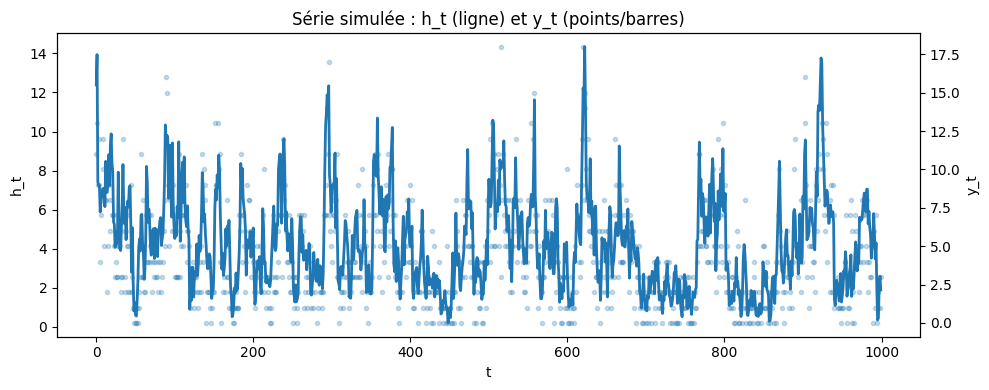

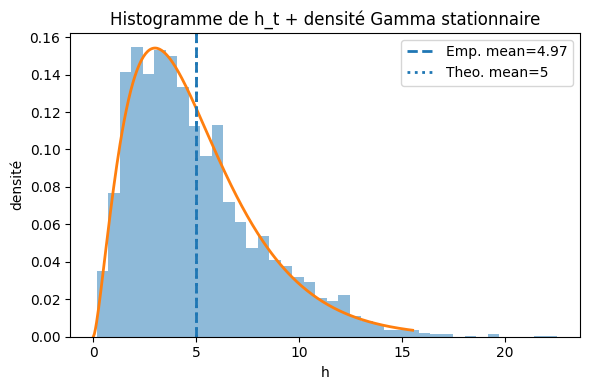

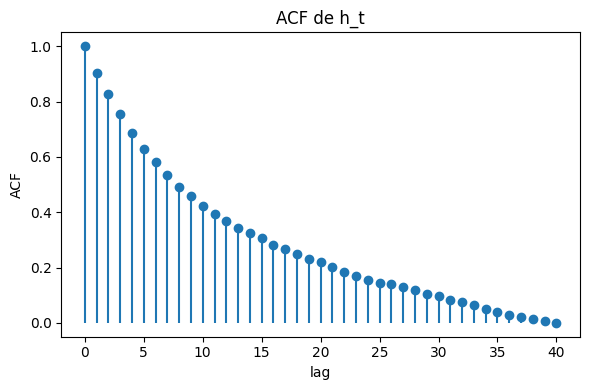

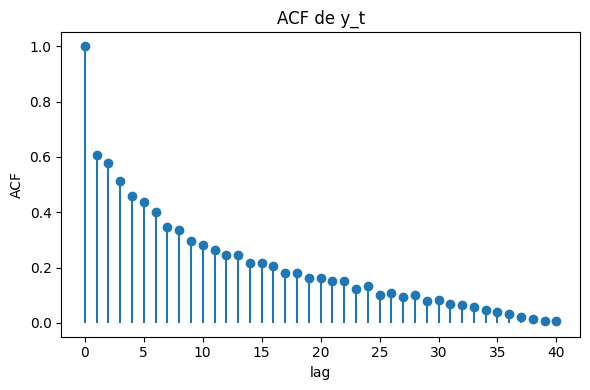

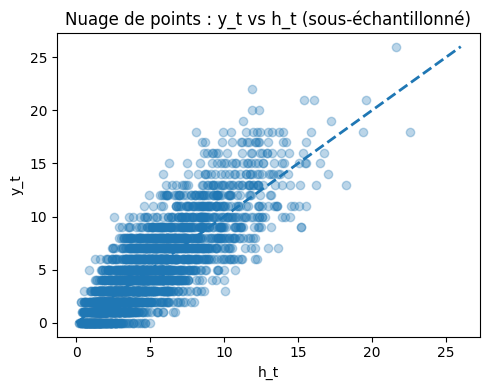

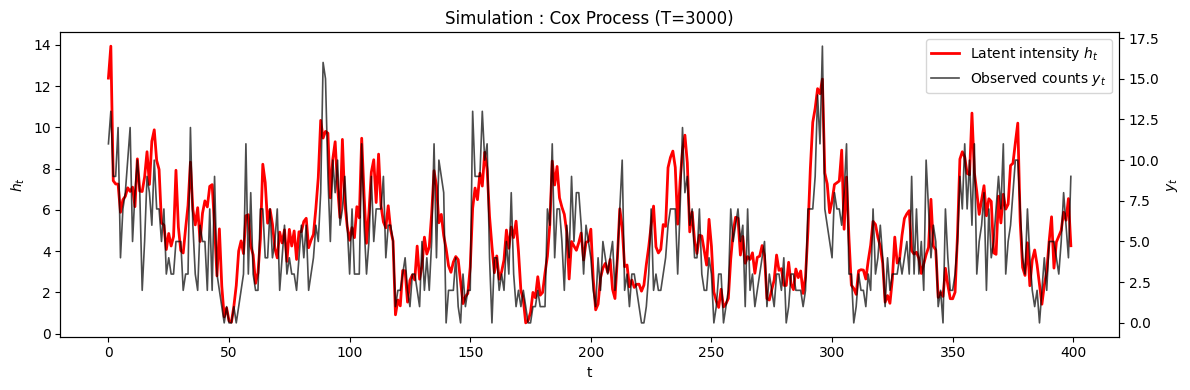

In [4]:
pl.plot_time_series(y, h, T_show=1000, start=0, use_bars=False)
pl.plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
pl.plot_acf_h(h, lags=40, burn=200)
pl.plot_acf_y(y, lags=40, burn=200)
pl.plot_scatter_y_h(y, h, max_points=3000)
pl.plot_overlay_clean(y, h, T_show=400, start=0)

## Seeing the impact of the choice of Z

In [18]:
Z_list = [20, 30, 40, 50, 75, 100, 200, 400, 800]


loglikes = []
times = []
max_pZ_list = []

# permet de compiler avec Numba une première fois (comme échauffement pour pas prendre en compte ce temps dans les résultats)
_ = ef.ExactFilter(y, Z_trunc=Z_list[0]).log_likelihood(
    **TRUE_PARAMS
)

# Z-truncation study

for Z in Z_list:
    f = ef.ExactFilter(y, Z_trunc=Z)

    t0 = time.time()
    ll, max_pZ = f.log_likelihood(
        return_diag=True,
        **TRUE_PARAMS
    )
    t1 = time.time()

    loglikes.append(ll)
    times.append(t1 - t0)
    max_pZ_list.append(max_pZ)

    print(
        f"Z={Z:4d} | log-like={ll:12.2f} | "
        f"time={t1-t0:6.2f}s | max P(z=Z|y)={max_pZ:.2e}"
    )


Z=  20 | log-like=    -9910.75 | time=  0.09s | max P(z=Z|y)=5.79e-01
Z=  30 | log-like=    -8186.72 | time=  0.20s | max P(z=Z|y)=4.26e-01
Z=  40 | log-like=    -7487.87 | time=  0.31s | max P(z=Z|y)=3.11e-01
Z=  50 | log-like=    -7200.38 | time=  0.49s | max P(z=Z|y)=2.21e-01
Z=  75 | log-like=    -7031.51 | time=  1.03s | max P(z=Z|y)=7.31e-02
Z= 100 | log-like=    -7021.58 | time=  1.95s | max P(z=Z|y)=1.01e-02
Z= 200 | log-like=    -7021.35 | time=  7.30s | max P(z=Z|y)=6.27e-14
Z= 400 | log-like=    -7021.35 | time= 30.09s | max P(z=Z|y)=1.91e-35
Z= 800 | log-like=    -7021.35 | time=117.11s | max P(z=Z|y)=1.05e-81


In [19]:
# Référence
ll_ref = loglikes[-1]

# DataFrame
results = pd.DataFrame({
    "Z": Z_list,
    "log_likelihood": loglikes,
    "Diff_logL_vs_Zmax": [ll - ll_ref for ll in loglikes],
    "time_sec": times,
    "max_P_z_eq_Z": max_pZ_list
})

# Enregistrement en CSV
results.to_csv("results_Z_truncation.csv", index=False)
results

,Z,log_likelihood,Diff_logL_vs_Zmax,time_sec,max_P_z_eq_Z
0,20,-9910.746198,-2.889397e+03,0.088467,5.794250e-01
1,30,-8186.717311,-1.165368e+03,0.196151,4.258677e-01
2,40,-7487.874328,-4.665248e+02,0.306626,3.105382e-01
3,50,-7200.381857,-1.790323e+02,0.488400,2.207321e-01
4,75,-7031.507038,-1.015748e+01,1.026412,7.310483e-02
5,100,-7021.579747,-2.301873e-01,1.951406,1.005345e-02
6,200,-7021.349560,1.818989e-12,7.296757,6.274520e-14
7,400,-7021.349560,0.000000e+00,30.093023,1.905215e-35
8,800,-7021.349560,0.000000e+00,117.108392,1.052568e-81


In [20]:
results = pd.read_csv("results_Z_truncation.csv")
results

,Z,log_likelihood,Diff_logL_vs_Zmax,time_sec,max_P_z_eq_Z
0,20,-9910.746198,-2.889397e+03,0.088467,5.794250e-01
1,30,-8186.717311,-1.165368e+03,0.196151,4.258677e-01
2,40,-7487.874328,-4.665248e+02,0.306626,3.105382e-01
3,50,-7200.381857,-1.790323e+02,0.488400,2.207321e-01
4,75,-7031.507038,-1.015748e+01,1.026412,7.310483e-02
5,100,-7021.579747,-2.301873e-01,1.951406,1.005345e-02
6,200,-7021.349560,1.818989e-12,7.296757,6.274520e-14
7,400,-7021.349560,0.000000e+00,30.093023,1.905215e-35
8,800,-7021.349560,0.000000e+00,117.108392,1.052568e-81


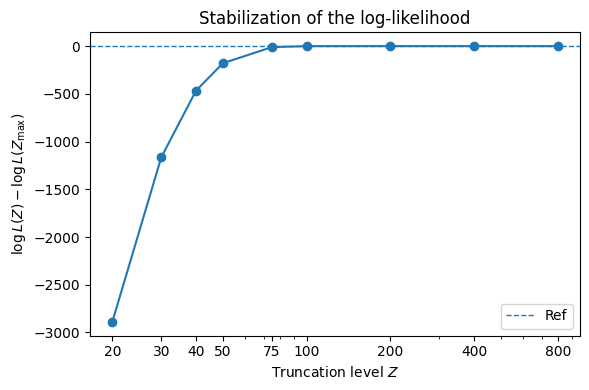

In [21]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["Diff_logL_vs_Zmax"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1, label=r"Ref")

plt.xscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$")
plt.ylabel(r"$\log L(Z) - \log L(Z_{\max})$")
plt.title("Stabilization of the log-likelihood")
plt.legend()
plt.tight_layout()
plt.show()


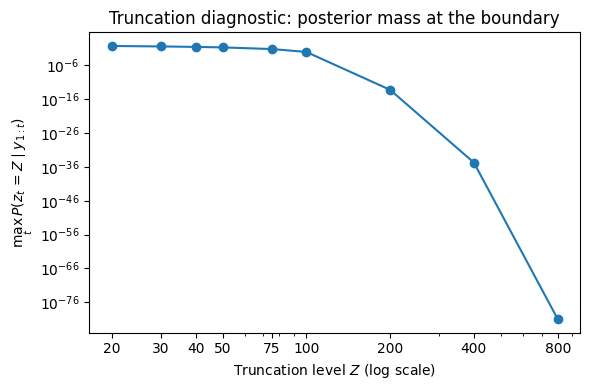

In [22]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["max_P_z_eq_Z"], marker="o")

plt.xscale("log")
plt.yscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$ (log scale)")
plt.ylabel(r"$\max_t\, P(z_t = Z \mid y_{1:t})$")
plt.title("Truncation diagnostic: posterior mass at the boundary")
plt.tight_layout()
plt.show()


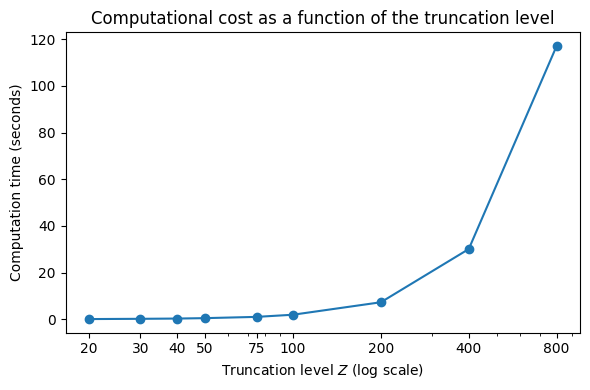

In [23]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["time_sec"], marker="o")

plt.xscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$ (log scale)")
plt.ylabel("Computation time (seconds)")
plt.title("Computational cost as a function of the truncation level")
plt.tight_layout()
plt.show()


## Comparaison avec un particle filter 

Exact filter warm-up...

Running PF V1 scatter...


phi grid: 100%|██████████| 80/80 [54:05<00:00, 40.57s/it]


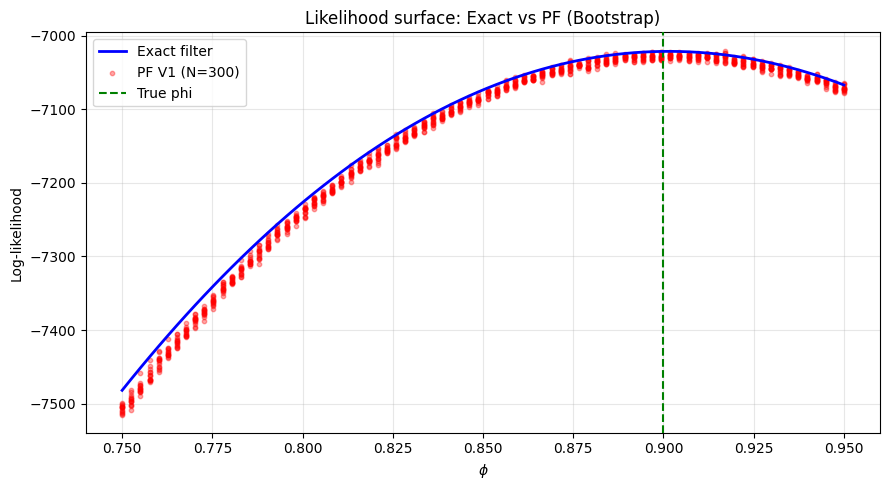

In [ ]:
# ======================================================
# Settings (DEMO NUAGE - comme dans le papier)
# ======================================================
TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}

Z_REF = 200

N_PARTICLES = 300      # ↓ volontairement petit → plus de bruit
R = 15                 # ↑ plus de répétitions → nuage épais
SEED0 = 123

phi_grid = np.linspace(0.75, 0.95, 80)  # ↑ grille plus dense

# ======================================================
# Exact filter (warm-up + reference)
# ======================================================
print("Exact filter warm-up...")
exact_filter = ef.ExactFilter(y, Z_trunc=Z_REF)
_ = exact_filter.log_likelihood(**TRUE_PARAMS)  # compile numba

# ======================================================
# Containers
# ======================================================
ll_exact = np.empty(phi_grid.size)
phi_scatter = []
ll_pf_scatter = []

# ======================================================
# Main loop : Exact + PF V1
# ======================================================
print("\nRunning PF scatter...")

for i in trange(phi_grid.size, desc="phi grid"):
    phi = phi_grid[i]

    # Exact likelihood (1 fois)
    ll_exact[i] = exact_filter.log_likelihood(
        phi=phi,
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"]
    )

    # PF V1 (R fois)
    for r in range(R):
        ll_hat = pf1.loglik_pf_once(
            y,
            phi=phi,
            nu=TRUE_PARAMS["nu"],
            c=TRUE_PARAMS["c"],
            N=N_PARTICLES,
            seed=SEED0 + 1000 * i + r
        )
        phi_scatter.append(phi)
        ll_pf_scatter.append(ll_hat)

# ======================================================
# Plot : Exact + PF V1
# ======================================================
plt.figure(figsize=(9, 5))

plt.plot(
    phi_grid,
    ll_exact,
    lw=2,
    color="blue",
    label="Exact filter",
    zorder=5
)

plt.scatter(
    phi_scatter,
    ll_pf_scatter,
    s=10,
    alpha=0.35,
    color="red",
    label=f"PF V1 (N={N_PARTICLES})",
    zorder=2
)

plt.axvline(
    TRUE_PARAMS["phi"],
    color="green",
    ls="--",
    label="True phi",
    zorder=4
)

plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Likelihood surface: Exact vs PF (Bootstrap)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Effet N différents

<>:93: SyntaxWarning: invalid escape sequence '\p'
<>:93: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_529563/1639160826.py:93: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(TRUE_PARAMS["phi"], color="green", ls="--", lw=1, label="True $\phi$")
/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Exact filter warm-up...
Computing exact likelihood curve...


Exact LL (phi grid): 100%|██████████| 150/150 [19:15<00:00,  7.71s/phi]



=== Running Particle Filter for N = 100 ===


PF LL (N=100): 100%|██████████| 3000/3000 [51:21<00:00,  1.03s/eval] 


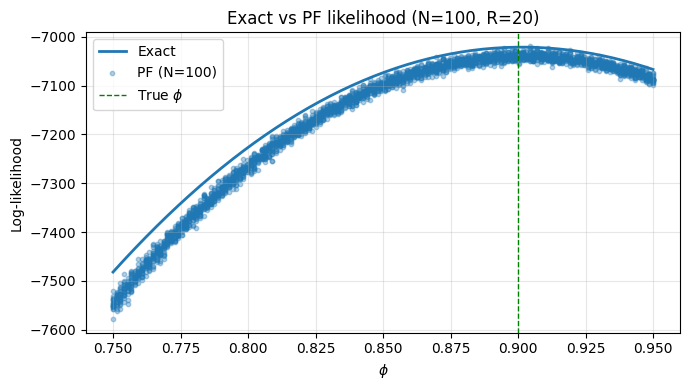

Saved: figures_pf_N/likelihood_surface_N100.png

=== Running Particle Filter for N = 200 ===


PF LL (N=200): 100%|██████████| 3000/3000 [1:28:17<00:00,  1.77s/eval]


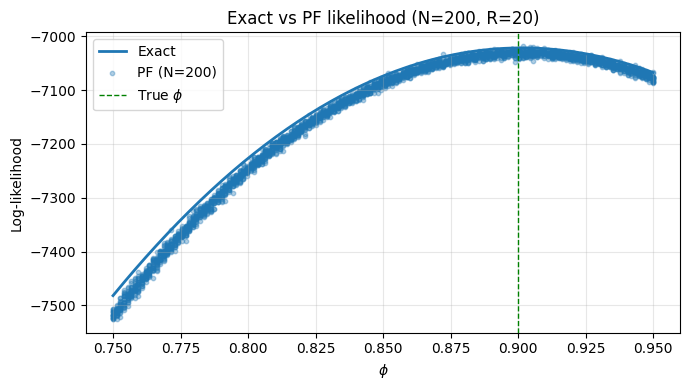

Saved: figures_pf_N/likelihood_surface_N200.png

=== Running Particle Filter for N = 300 ===


PF LL (N=300): 100%|██████████| 3000/3000 [2:06:29<00:00,  2.53s/eval]  


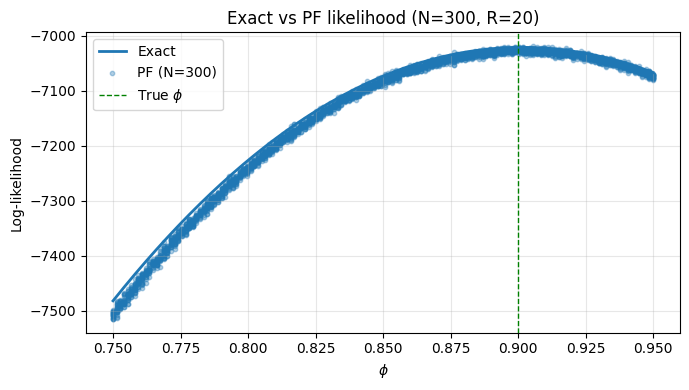

Saved: figures_pf_N/likelihood_surface_N300.png

=== Running Particle Filter for N = 500 ===


PF LL (N=500): 100%|██████████| 3000/3000 [3:04:02<00:00,  3.68s/eval]  


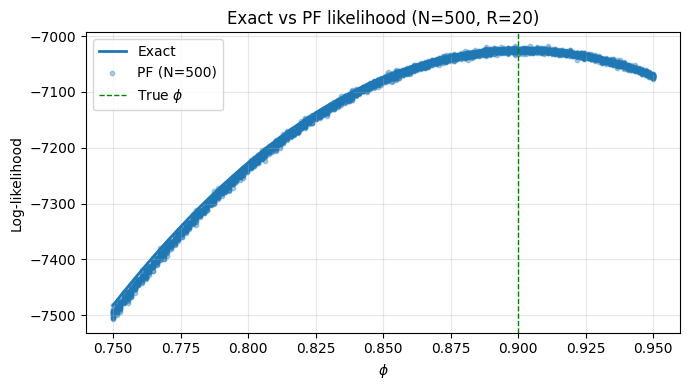

Saved: figures_pf_N/likelihood_surface_N500.png

=== Running Particle Filter for N = 1000 ===


PF LL (N=1000):   2%|▏         | 50/3000 [05:17<5:12:11,  6.35s/eval]
/tmp/ipykernel_529563/1639160826.py:93: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(TRUE_PARAMS["phi"], color="green", ls="--", lw=1, label="True $\phi$")


KeyboardInterrupt: 

In [ ]:
# pf_vs_exact_with_progress.py
# ------------------------------------------------------------
# Exact vs Particle Filter likelihood surface
# with progress bars (ETA)
# ------------------------------------------------------------

# ------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------

TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}

Z_REF = 200
phi_grid = np.linspace(0.75, 0.95, 150)

N_list = [100, 200, 300, 500, 1000, 2000]
R = 20                      # number of PF repetitions
SEED0 = 123

OUTDIR = "figures_pf_N"
os.makedirs(OUTDIR, exist_ok=True)

# ------------------------------------------------------------
# ASSUMED AVAILABLE OBJECTS
# ------------------------------------------------------------
# y               : observed data
# ef.ExactFilter  : exact filter class
# pf1             : particle filter object with method:
#                   loglik_pf_once(y, phi, nu, c, N, seed)
# ------------------------------------------------------------

# ------------------------------------------------------------
# EXACT FILTER: WARM-UP + REFERENCE CURVE
# ------------------------------------------------------------

print("Exact filter warm-up...")
exact_filter = ef.ExactFilter(y, Z_trunc=Z_REF)
_ = exact_filter.log_likelihood(**TRUE_PARAMS)  # Numba compilation

print("Computing exact likelihood curve...")
ll_exact = np.empty(phi_grid.size)

for i, phi in enumerate(tqdm(phi_grid, desc="Exact LL (phi grid)", unit="phi")):
    ll_exact[i] = exact_filter.log_likelihood(
        phi=float(phi),
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"]
    )


# ------------------------------------------------------------
# PARTICLE FILTER: LOOP OVER N, SAVE+SHOW AS WE GO
# ------------------------------------------------------------

pf_results = {}

for N_PARTICLES in N_list:

    print(f"\n=== Running Particle Filter for N = {N_PARTICLES} ===")

    total_evals = phi_grid.size * R
    ll_pf_mat = np.empty((phi_grid.size, R), dtype=float)

    with tqdm(total=total_evals, desc=f"PF LL (N={N_PARTICLES})", unit="eval") as pbar:
        for i, phi in enumerate(phi_grid):
            for r in range(R):
                ll_pf_mat[i, r] = pf1.loglik_pf_once(
                    y,
                    phi=float(phi),
                    nu=TRUE_PARAMS["nu"],
                    c=TRUE_PARAMS["c"],
                    N=int(N_PARTICLES),
                    seed=SEED0 + 1000 * i + r
                )
                pbar.update(1)

    # Optionnel: stocker (utile si tu veux refaire des plots sans recalculer)
    pf_results[N_PARTICLES] = ll_pf_mat.copy()

    # Scatter pour reproduire le "nuage" du papier
    phi_scatter = np.repeat(phi_grid, R)
    ll_pf_scatter = ll_pf_mat.reshape(-1)

    # ---- FIGURE INDIVIDUELLE (save + show tout de suite)
    plt.figure(figsize=(7, 4))
    plt.plot(phi_grid, ll_exact, lw=2, label="Exact")
    plt.scatter(phi_scatter, ll_pf_scatter, s=10, alpha=0.35, label=f"PF (N={N_PARTICLES})")
    plt.axvline(TRUE_PARAMS["phi"], color="green", ls="--", lw=1, label="True $\phi$")

    plt.xlabel(r"$\phi$")
    plt.ylabel("Log-likelihood")
    plt.title(f"Exact vs PF likelihood (N={N_PARTICLES}, R={R})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    fname = os.path.join(OUTDIR, f"likelihood_surface_N{N_PARTICLES}.png")
    plt.savefig(fname, dpi=300)

    plt.show()      # affiche tout de suite (en notebook) / ou ouvre fenêtre (script)
    plt.close()     # libère la mémoire

    print(f"Saved: {fname}")


In [ ]:
import os

OUTDIR = "figures_pf_N"
os.makedirs(OUTDIR, exist_ok=True)

for N, ll_pf_mat in pf_results.items():
    # ll_pf_mat: shape = (len(phi_grid), R)
    phi_scatter = np.repeat(phi_grid, ll_pf_mat.shape[1])
    ll_pf_scatter = ll_pf_mat.reshape(-1)

    df = pd.DataFrame({
        "phi": phi_scatter,
        "loglik_pf": ll_pf_scatter
    })

    fname = os.path.join(OUTDIR, f"pf_scatter_N{N}.csv")
    df.to_csv(fname, index=False)
    print(f"Saved PF CSV for N={N} -> {fname}")

# Exact
df_exact = pd.DataFrame({
    "phi": phi_grid,
    "loglik_exact": ll_exact
})
df_exact.to_csv(os.path.join(OUTDIR, "exact_likelihood.csv"), index=False)
print("Exact likelihood saved as CSV.")


Saved PF CSV for N=100 -> figures_pf_N/pf_scatter_N100.csv
Saved PF CSV for N=200 -> figures_pf_N/pf_scatter_N200.csv
Saved PF CSV for N=300 -> figures_pf_N/pf_scatter_N300.csv
Saved PF CSV for N=500 -> figures_pf_N/pf_scatter_N500.csv
Exact likelihood saved as CSV.


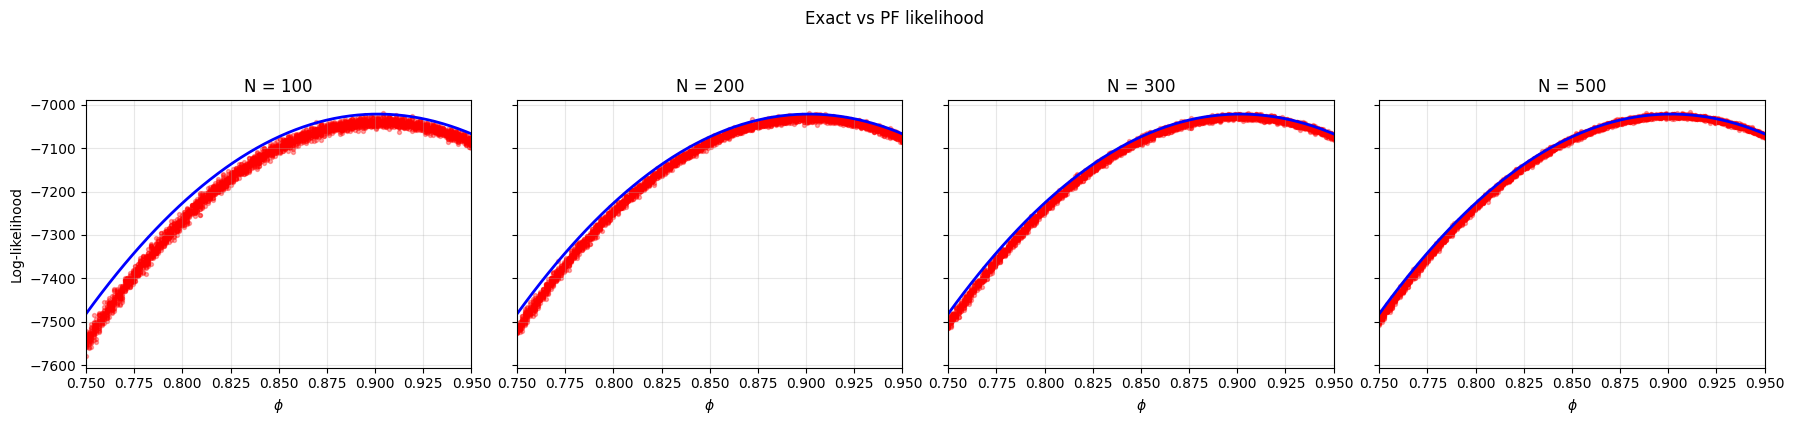

In [ ]:
OUTDIR = "figures_pf_N"
N_list = [100, 200, 300, 500]

# --- Load exact once
df_exact = pd.read_csv(f"{OUTDIR}/exact_likelihood.csv")
phi_grid = df_exact["phi"].values
ll_exact = df_exact["loglik_exact"].values

# --- Figure with subplots
fig, axes = plt.subplots(
    1, len(N_list),
    figsize=(4.5 * len(N_list), 4),
    sharey=True
)

if len(N_list) == 1:
    axes = [axes]

for ax, N in zip(axes, N_list):

    # Load PF for this N
    df_pf = pd.read_csv(f"{OUTDIR}/pf_scatter_N{N}.csv")
    phi_scatter = df_pf["phi"].values
    ll_pf_scatter = df_pf["loglik_pf"].values

    # Exact
    ax.plot(phi_grid, ll_exact, linewidth=2, color="blue")

    # PF scatter
    ax.scatter(
        phi_scatter,
        ll_pf_scatter,
        s=8,
        alpha=0.35,
        color="red"
    )

    # Zoom
    ax.set_xlim(0.75, 0.95)

    # Titles / labels
    ax.set_title(f"N = {N}")
    ax.set_xlabel(r"$\phi$")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Log-likelihood")

# --- Global title
fig.suptitle("Exact vs PF likelihood", y=1.05)

fig.tight_layout()
plt.show()


In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "figures_pf_N_bis"
N_list = [100, 200, 300, 500]

theta_true = 0.9  # <<< mets ici la vraie valeur de theta / phi

# Create output directory if needed
os.makedirs(OUTDIR, exist_ok=True)

# --- Load exact once
df_exact = pd.read_csv(f"{OUTDIR}/exact_likelihood.csv")
phi_grid = df_exact["phi"].values
ll_exact = df_exact["loglik_exact"].values

for N in N_list:

    # Load PF for this N
    df_pf = pd.read_csv(f"{OUTDIR}/pf_scatter_N{N}.csv")
    phi_scatter = df_pf["phi"].values
    ll_pf_scatter = df_pf["loglik_pf"].values

    # --- Create figure
    fig, ax = plt.subplots(figsize=(5, 4))

    # Exact curve
    ax.plot(
        phi_grid, ll_exact,
        linewidth=2,
        color="blue",
        label="Exact"
    )

    # PF scatter
    ax.scatter(
        phi_scatter,
        ll_pf_scatter,
        s=8,
        alpha=0.35,
        color="red",
        label="PF"
    )

    # True theta (vertical dashed line)
    ax.axvline(
        theta_true,
        linestyle="--",
        linewidth=2,
        color="black",
        label=r"True $\phi$"
    )

    # Formatting
    ax.set_xlim(0.75, 0.95)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel("Log-likelihood")
    ax.set_title(f"Exact vs PF likelihood (N = {N})")
    ax.grid(alpha=0.3)
    ax.legend()

    # --- Save figure
    fname = f"{OUTDIR}/likelihood_N{N}.png"
    fig.tight_layout()
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved: {fname}")


Saved: figures_pf_N_bis/likelihood_N100.png
Saved: figures_pf_N_bis/likelihood_N200.png
Saved: figures_pf_N_bis/likelihood_N300.png
Saved: figures_pf_N_bis/likelihood_N500.png


## Other Noisy parameter

In [ ]:
# pf_vs_exact_smallT_noisy.py
# ------------------------------------------------------------
# Exact vs Particle Filter likelihood surface
# SMALL T + SMALL N (to highlight PF variability)
# ------------------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ------------------------------------------------------------
# USER SETTINGS (NOISY SETUP)

TRUE_PARAMS_SMALLT = {"phi": 0.85, "nu": 2.5, "c": 0.5}
T_sim_bis = 50000

sim_bis = cox.CoxProcessSimulation(T=T_sim_bis, **TRUE_PARAMS_SMALLT, seed=123)

y_sim, h_sim, z_sim, lam_sim = sim_bis.simulate(init="burnin",burn_in=500, h0=1.0, return_lambda=True)

Z_REF_SMALLT = 200
phi_grid_smallT = np.linspace(0.8, 0.92, 1000)

N_list_smallT = [10000]   # deliberately small
R_smallT = 50
SEED0 = 123

OUTDIR_SMALLT = "figures_pf_N_smallT"
os.makedirs(OUTDIR_SMALLT, exist_ok=True)

# ------------------------------------------------------------
# DATA (reuse y, but truncate)
# ------------------------------------------------------------

T_SMALL = 35000
y_small = y_sim[:T_SMALL]

# ------------------------------------------------------------
# EXACT FILTER
# ------------------------------------------------------------

print("Exact filter warm-up (SMALL T)...")
exact_filter_small = ef.ExactFilter(y_small, Z_trunc=Z_REF_SMALLT)
_ = exact_filter_small.log_likelihood(**TRUE_PARAMS_SMALLT)

print("Computing exact likelihood curve (SMALL T)...")
ll_exact_small = np.empty(phi_grid_smallT.size)

for i, phi in enumerate(tqdm(phi_grid_smallT, desc="Exact LL small T")):
    ll_exact_small[i] = exact_filter_small.log_likelihood(
        phi=float(phi),
        nu=TRUE_PARAMS_SMALLT["nu"],
        c=TRUE_PARAMS_SMALLT["c"]
    )

# ------------------------------------------------------------
# PARTICLE FILTER (NOISY BY DESIGN)
# ------------------------------------------------------------

pf_results_smallT = {}

for N_PARTICLES in N_list_smallT:

    print(f"\n=== PF SMALL T, N = {N_PARTICLES} ===")

    ll_pf_mat = np.empty((phi_grid_smallT.size, R_smallT))

    with tqdm(
        total=phi_grid_smallT.size * R_smallT,
        desc=f"PF small T (N={N_PARTICLES})"
    ) as pbar:

        for i, phi in enumerate(phi_grid_smallT):
            for r in range(R_smallT):
                ll_pf_mat[i, r] = pf1.loglik_pf_once(
                    y_small,
                    phi=float(phi),
                    nu=TRUE_PARAMS_SMALLT["nu"],
                    c=TRUE_PARAMS_SMALLT["c"],
                    N=int(N_PARTICLES),
                    seed=SEED0 + 1000 * i + r
                )
                pbar.update(1)

    pf_results_smallT[N_PARTICLES] = ll_pf_mat.copy()

    # --------------------------------------------------------
    # Plot immediately (ZOOMED)
    # --------------------------------------------------------

    phi_scatter = np.repeat(phi_grid_smallT, R_smallT)
    ll_pf_scatter = ll_pf_mat.reshape(-1)

    plt.figure(figsize=(7, 4))
    plt.plot(phi_grid_smallT, ll_exact_small, lw=2, label="Exact")
    plt.scatter(
        phi_scatter,
        ll_pf_scatter,
        s=10,
        alpha=0.35,
        color="red",
        label=f"PF (N={N_PARTICLES})"
    )

    plt.xlim(0.8, 0.92)

    # automatic y-zoom
    mask = (phi_scatter >= 0.8) & (phi_scatter <= 0.92)
    ymin, ymax = ll_pf_scatter[mask].min(), ll_pf_scatter[mask].max()
    plt.ylim(ymin - 10, ymax + 10)

    plt.xlabel(r"$\phi$")
    plt.ylabel("Log-likelihood")
    plt.title(f"Exact vs PF likelihood (T=300, N={N_PARTICLES})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    fname = os.path.join(
        OUTDIR_SMALLT,
        f"likelihood_surface_T300_N{N_PARTICLES}.png"
    )
    plt.savefig(fname, dpi=300)
    plt.show()
    plt.close()

    print(f"Saved: {fname}")


Exact filter warm-up (SMALL T)...
Computing exact likelihood curve (SMALL T)...


Exact LL small T:   4%|▍         | 45/1000 [1:10:05<25:08:12, 94.76s/it]

## Données réelles 